# Classificação de categoria de jogos da Steam
## Projeto da disciplina SCC0230 - Inteligência Artificial

## Membros

* Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

* Arthur Santorum Lorenzetto - arts.lorenzetto@usp.br - 12559465

* Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490 (Vice-Líder)

* Gustavo Silva de Oliveira - gustavo.oliveira03@usp.br - 12567231 

* Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472 

* Pedro Henrique de Freitas Maçonetto - pedromaconetto@usp.br - 12675419 (Líder)

* Vitor Okubo Ianella - vitorok.03@gmail.com - 12559451


# Desenvolvimento

In [47]:
# Importando Bibliotecas
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

In [48]:
# Removendo warnings chatos
warnings.filterwarnings('ignore')

In [49]:
# Carregando Dados da Steam
df = pd.read_csv('steam_metadados.csv')
df.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


---
## Tratamento dos Dados

In [50]:
# Removendo colunas inúteis
df.drop(columns=['platforms', 'developer', 'publisher', 'achievements'], inplace=True)

# Removendo NaN
df.dropna(inplace=True)

In [51]:
# Classificando apenas pelo gênero principal (primeiro)
df['main_genre'] = df['genres'].apply(lambda x: str(x).split(';')[0])
df.main_genre

0           Action
1           Action
2           Action
3           Action
4           Action
           ...    
27070    Adventure
27071       Action
27072       Action
27073    Adventure
27074    Adventure
Name: main_genre, Length: 27075, dtype: object

In [52]:
# Total de avaliações de um jogo
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings'] 
df.total_ratings

0        127873
1          3951
2          3814
3          1540
4          5538
          ...  
27070         3
27071         9
27072         1
27073         2
27074         4
Name: total_ratings, Length: 27075, dtype: int64

In [53]:
# Reestruturando valores de idade mínima
def age_transform(age):
  age = int(age)
  if age == 3 or age == 7:
    return 0
  else:
    return age
  
df['required_age'] = df['required_age'].apply(age_transform)
df.required_age

0        0
1        0
2        0
3        0
4        0
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: required_age, Length: 27075, dtype: int64

In [54]:
# Jogo Singleplayer ou Multiplayer
def multi_or_single(category):
  category = str(category).split(';')
  if 'Multi-player' in category:
    return 1 # Multiplayer
  else:
    return 0 # Singleplayer

df['is_multiplayer'] = df['categories'].apply(multi_or_single)
del df['categories']

In [55]:
# Estimativa do número de compradores
def mean_owners(text):
    txt_min, txt_max = text.split('-')
    return (int(txt_max) + int(txt_min)) / 2
    
df['owners'] =  df['owners'].apply(mean_owners)

In [56]:
# Coletando Ano de lançamento do jogo 
df['year_release'] = df['release_date'].apply(lambda x: str(x).split('-')[0])
df.year_release

0        2000
1        1999
2        2003
3        2001
4        1999
         ... 
27070    2019
27071    2019
27072    2019
27073    2019
27074    2019
Name: year_release, Length: 27075, dtype: object

In [57]:
# Dicotomizando jogos em Ação ou Não-Ação
df['is_action'] = np.where(df['main_genre'] == "Action", 1, 0)
df.is_action

0        1
1        1
2        1
3        1
4        1
        ..
27070    0
27071    1
27072    1
27073    0
27074    0
Name: is_action, Length: 27075, dtype: int32

In [58]:
# Dados tratados
df.head()

,appid,name,release_date,english,required_age,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,main_genre,total_ratings,is_multiplayer,year_release,is_action
0,10,Counter-Strike,2000-11-01,1,0,Action,Action;FPS;Multiplayer,124534,3339,17612,317,15000000.0,7.19,Action,127873,1,2000,1
1,20,Team Fortress Classic,1999-04-01,1,0,Action,Action;FPS;Multiplayer,3318,633,277,62,7500000.0,3.99,Action,3951,1,1999,1
2,30,Day of Defeat,2003-05-01,1,0,Action,FPS;World War II;Multiplayer,3416,398,187,34,7500000.0,3.99,Action,3814,1,2003,1
3,40,Deathmatch Classic,2001-06-01,1,0,Action,Action;FPS;Multiplayer,1273,267,258,184,7500000.0,3.99,Action,1540,1,2001,1
4,50,Half-Life: Opposing Force,1999-11-01,1,0,Action,FPS;Action;Sci-fi,5250,288,624,415,7500000.0,3.99,Action,5538,1,1999,1


## Verificando Correlação dos Atributos

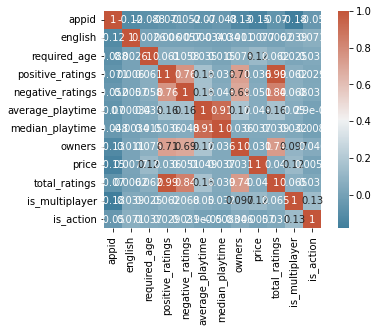

In [59]:
correlation = df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(
    correlation, 
    cmap=cmap,
    square=True, 
    annot = True
)

In [60]:
# Porcentagem de ação e não-ação
px.pie(df,'is_action')

# Aplicando Modelos de Classificação

## k-Nearest Neighbor (KNN)

In [61]:
Y = df['is_action']
X = df[['english', 'is_multiplayer', 'total_ratings', 'owners', 'price', 'median_playtime', 'year_release']]

# Normalizando dados
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [62]:
# Separando em conjunto de treinamento e teste (Hold-Out)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [63]:
# Escolhendo melhor número de vizinhos k
scores = []

range_k = range(1, 30)

for i in range_k:
  neighbor = KNeighborsClassifier(n_neighbors=i, p=2)
  neighbor.fit(X_train, Y_train)

  score = neighbor.score(X_test, Y_test, sample_weight=None)
  scores.append(score)

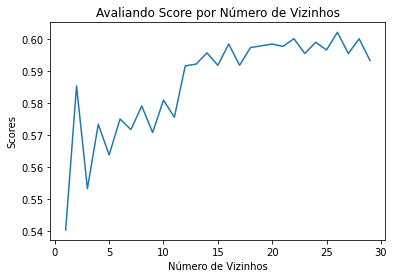

In [64]:
# Plotando Score por Número de vizinhos
plt.plot(range_k, scores)

plt.xlabel("Número de Vizinhos")
plt.ylabel("Scores")
plt.title("Avaliando Score por Número de Vizinhos")

plt.show()

In [65]:
best_score = max(scores)
print(f"O Score do melhor modelo foi {best_score}")

O Score do melhor modelo foi 0.6022160664819944


In [66]:
# Escolhendo o k com maior Score
best_k = range_k[scores.index(best_score)]
print(f"O melhor número de vizinhos k foi {best_k}.")

O melhor número de vizinhos k foi 26.


In [67]:
# Ajustando modelo KNN com k=18
knn_model = KNeighborsClassifier(n_neighbors=best_k, p=2)

# Treinando com conjunto de treinamento
knn_model.fit(X_train, Y_train)

# Predizendo para o conjunto de teste
results = knn_model.predict(X_test)
results

array([0, 0, 1, ..., 0, 1, 0])

### Medidas de Avaliação do KNN

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [69]:
# Matriz de Confusão
conf_matrix = confusion_matrix(Y_test, results)
print("True Positive: ", conf_matrix[0, 0])
print("False Positive: ", conf_matrix[1, 0])
print("True Negative: ", conf_matrix[0, 1])
print("False Negative: ", conf_matrix[1, 1])

print(conf_matrix)

True Positive:  2635
False Positive:  1616
True Negative:  538
False Negative:  626
[[2635  538]
 [1616  626]]


In [70]:
# Métrica de Revocação
recall_score(Y_test, results)

0.2792149866190901

In [71]:
# Métrica de Precisão
precision_score(Y_test, results)

0.5378006872852233

---
## Classificação por Árvore de Decisão

In [72]:
# Escolhendo melhor profundidade da arvore
scores = []

range_p = range(1, 30)

for i in range_p:
  neighbor = tree.DecisionTreeClassifier(max_depth=i)
  neighbor.fit(X_train, Y_train)

  score = neighbor.score(X_test, Y_test, sample_weight=None)
  scores.append(score)

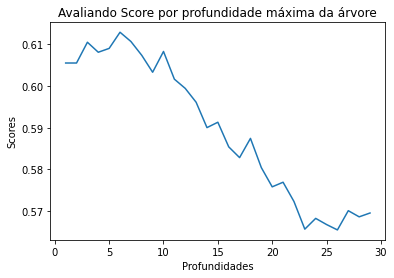

In [73]:
# Plotando Score por Número de vizinhos
plt.plot(range_k, scores)

plt.xlabel("Profundidades")
plt.ylabel("Scores")
plt.title("Avaliando Score por profundidade máxima da árvore")

plt.show()

In [74]:
best_score = max(scores)
print(f"O Score do melhor modelo foi {best_score}")

O Score do melhor modelo foi 0.612927054478301


In [75]:
# Escolhendo o k com maior Score
best_p = range_p[scores.index(best_score)]
print(f"O melhor número de vizinhos k foi {best_p}.")

O melhor número de vizinhos k foi 6.


In [76]:
# Ajustando modelo KNN com profundidade=6
clf = tree.DecisionTreeClassifier(max_depth=best_p)

# Treinando com conjunto de treinamento
clf.fit(X_train, Y_train)

# Predizendo para o conjunto de teste
results = clf.predict(X_test)
results

array([0, 0, 1, ..., 0, 0, 0])

In [77]:
# Modelo Decision Tree
clf = tree.DecisionTreeClassifier(max_depth=6)

# Treinando com conjunto de treinamento
clf.fit(X_train, Y_train)

# Predizendo com conjunto de teste
results = clf.predict(X_test)

# Avaliando Score do Modelo
clf.score(X_test, Y_test, sample_weight=None)

0.6127423822714682

### Medidas de avaliação do modelo:

In [78]:
# Matriz de Confusão
conf_matrix = confusion_matrix(Y_test,results)
print("True Positive: ", conf_matrix[0, 0])
print("False Positive: ", conf_matrix[1, 0])
print("True Negative: ", conf_matrix[0, 1])
print("False Negative: ", conf_matrix[1, 1])

conf_matrix

True Positive:  2884
False Positive:  1808
True Negative:  289
False Negative:  434


array([[2884,  289],
       [1808,  434]], dtype=int64)

In [79]:
# Métrica de Revocação
recall_score(Y_test,results)

0.1935771632471008

In [80]:
# Métrica de Precisão
precision_score(Y_test,results)

0.6002766251728907

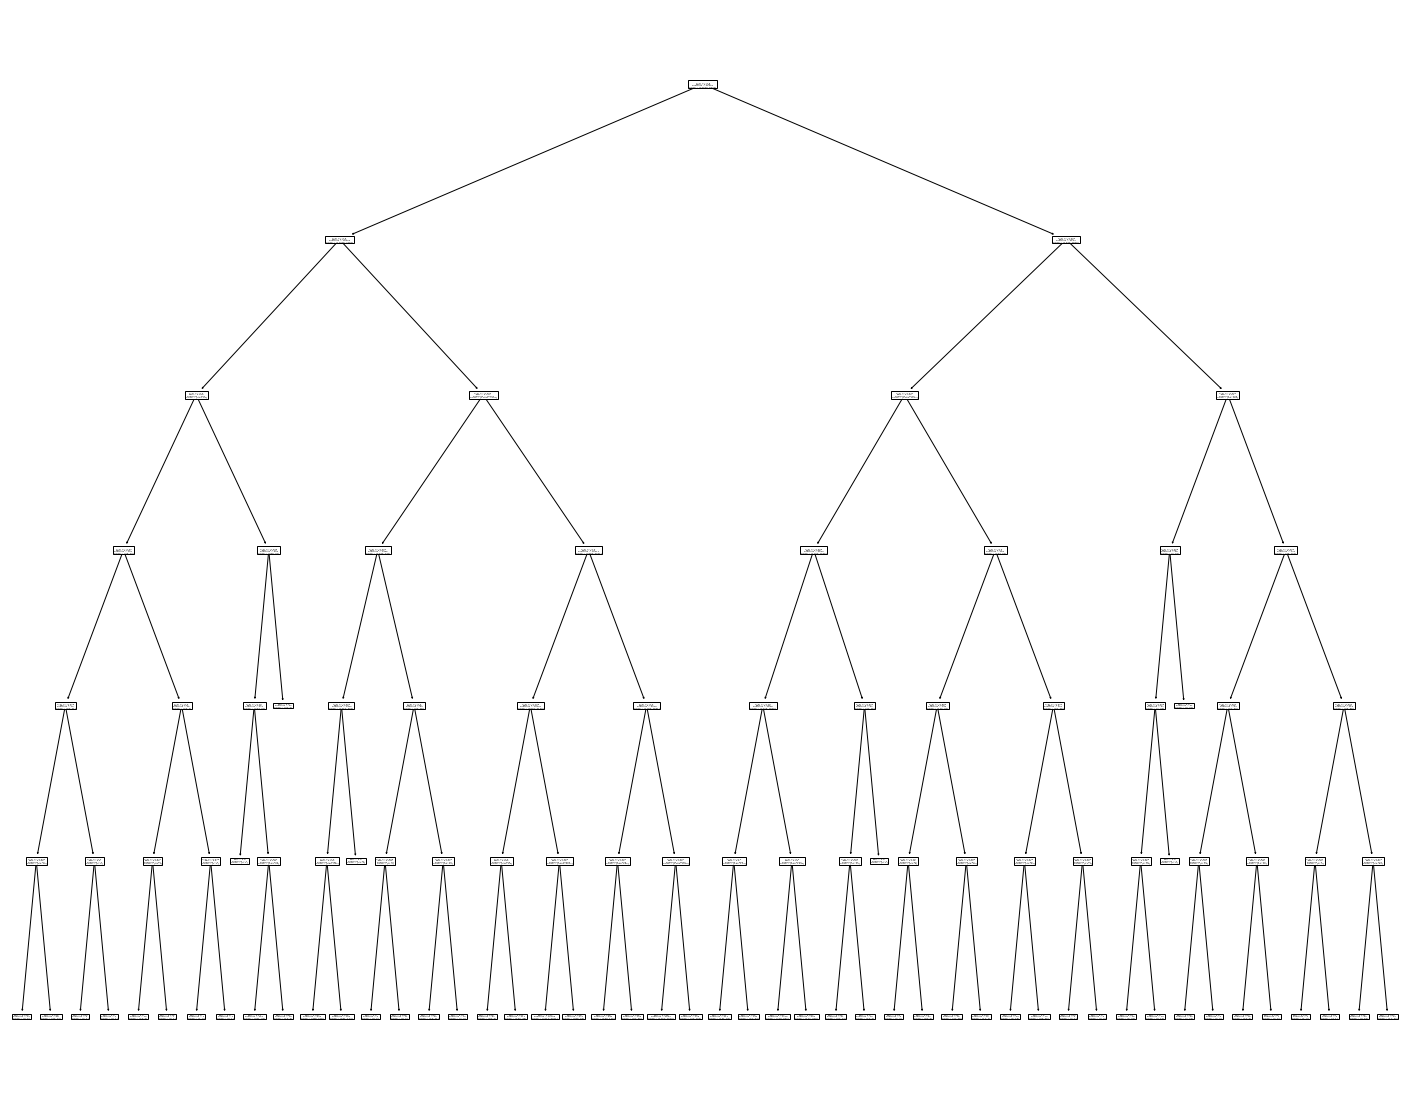

In [81]:
fig = plt.figure(figsize=(25, 20))

_ = tree.plot_tree(clf)

---
## Classificação por Random Forest

In [82]:
clf = RandomForestClassifier(random_state=42,max_depth=6)
clf = clf.fit(X_train, Y_train)

results = clf.predict(X_test)
clf.score(X_test, Y_test, sample_weight=None)

0.6112650046168052

In [83]:
recall_score(Y_test,results)

0.19848349687778769

In [84]:
precision_score(Y_test,results)

0.5909694555112882

---
# Modelo com tags dummy

## Criando variaveis dummy

In [85]:
# criando variáveis dummy

# separando as tags por ';'
df2 = df.drop('steamspy_tags', axis=1).join(df.steamspy_tags.str.split(';', expand=True)
             .stack().reset_index(drop=True, level=1).rename('tags'))

# selecionando tags unicas
tags = list(df2['tags'].unique())

# selecionando tags iguais aos generos 
invalid_tags = list(set(df['genres'].unique())&set(tags))

# removendo tags iguais aos generos
for tag in invalid_tags:
    tags.remove(tag)

def valid_tags(x):
    if x in invalid_tags:
        return None
    return x

# aplicando as tags validas nos dados
df2['tags'] = df2['tags'].apply(valid_tags)
df2.dropna(inplace=True)

# juntando dataframe de tags com original
dummies = pd.get_dummies(df2[['appid', 'tags']], columns=['tags']).groupby('appid').sum()
dum = dummies.columns
df = df.merge(dummies, how='inner', on='appid')


In [115]:
# Selecionando 100 covariaveis dentre todas
col = list(dum) + ['english', 'is_multiplayer', 'total_ratings', 'owners', 'price', 'median_playtime', 'year_release']
Y = df['is_action']
X = df[col]
X_new = SelectKBest(chi2, k=100).fit_transform(X, Y)


In [116]:
# Separando em conjunto de treinamento e teste (Hold-Out)
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42)

---
# Random Forest com Dummys

In [117]:
from sklearn.ensemble import RandomForestClassifier

# criando modelo
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, Y_train)

# verificando resultados
results = clf.predict(X_test)
clf.score(X_test, Y_test, sample_weight=None)

0.7688109161793373

In [95]:
# Matriz de Confusão
conf_matrix = confusion_matrix(Y_test,results)
print("True Positive: ", conf_matrix[0, 0])
print("False Positive: ", conf_matrix[1, 0])
print("True Negative: ", conf_matrix[0, 1])
print("False Negative: ", conf_matrix[1, 1])

conf_matrix

True Positive:  1365
False Positive:  586
True Negative:  320
False Negative:  294


array([[1365,  320],
       [ 586,  294]], dtype=int64)

In [96]:
# Métrica de Revocação
recall_score(Y_test,results)

0.3340909090909091

In [97]:
# Métrica de Precisão
precision_score(Y_test,results)

0.4788273615635179